## 定义基本函数

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import cv2

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常数
hbar = 1

def sgn(x):
    return np.sign(x)

def a(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def b(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def c(x, y, z):
    return np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)

def d(x, y, z):
    return -np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)


In [16]:

# from sympy import symbols, cos,sin, acos, sqrt, Abs, sign, latex
# from IPython.display import display, Math

# # 定义符号变量
# x, y, z, hbar = symbols('x y z hbar')

# # 定义符号表达式

# # a(x, y, z)
# a = cos(0.5 * acos(cos(x) * Abs(cos(z))**0.5)) * \
#     cos((cos(y) * (2 * Abs(cos(z))**0.5 * sign(cos(z)) - cos(x) * cos(z))) / hbar)

# # b(x, y, z)
# b = cos(0.5 * acos(cos(x) * Abs(cos(z))**0.5)) * \
#     sin((cos(y) * (2 * Abs(cos(z))**0.5 * sign(cos(z)) - cos(x) * cos(z))) / hbar)

# # c(x, y, z)
# c = sin(0.5 * acos(cos(x) * Abs(cos(z))**0.5)) * \
#     cos((cos(y) * (2 * Abs(cos(z))**0.5 * sign(cos(z)) + cos(x) * cos(z))) / hbar)

# # d(x, y, z)
# d = -sin(0.5 * acos(cos(x) * Abs(cos(z))**0.5)) * \
#     sin((cos(y) * (2 * Abs(cos(z))**0.5 * sign(cos(z)) + cos(x) * cos(z))) / hbar)

# # 使用 LaTeX 显示每个表达式
# display(Math(r'a(x, y, z) = ' + latex(a)))
# display(Math(r'b(x, y, z) = ' + latex(b)))
# display(Math(r'c(x, y, z) = ' + latex(c)))
# display(Math(r'd(x, y, z) = ' + latex(d)))



### 定义用到的函数

#### 已知abcd计算速度场

In [17]:
def compute_velocity_field_3d_np(x, y, z, dx, dy, dz):
    a_val = a(x, y, z)
    b_val = b(x, y, z)
    c_val = c(x, y, z)
    d_val = d(x, y, z)

    a_grad_x, a_grad_y, a_grad_z = np.gradient(a_val, dx, dy, dz)
    b_grad_x, b_grad_y, b_grad_z = np.gradient(b_val, dx, dy, dz)
    c_grad_x, c_grad_y, c_grad_z = np.gradient(c_val, dx, dy, dz)
    d_grad_x, d_grad_y, d_grad_z = np.gradient(d_val, dx, dy, dz)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)
    u_z = hbar * (a_val * b_grad_z - b_val * a_grad_z + c_val * d_grad_z - d_val * c_grad_z)

    return u_x, u_y, u_z

#### 已知速度场计算涡度场

In [18]:
def vorticity_3d(U_x, U_y, U_z, dx, dy, dz):
    dU_y_dz, dU_y_dy, dU_y_dx = np.gradient(U_y, dz, dy, dx)
    dU_z_dz, dU_z_dy, dU_z_dx = np.gradient(U_z, dz, dy, dx)
    dU_x_dz, dU_x_dy, dU_x_dx = np.gradient(U_x, dz, dy, dx)

    omega_x = dU_z_dy - dU_y_dz
    omega_y = dU_x_dz - dU_z_dx
    omega_z = dU_y_dx - dU_x_dy

    return omega_x, omega_y, omega_z

## 定义参数

In [19]:
# 定义网格
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
z = np.linspace(0, 2 * np.pi, size)
X, Y, Z = np.meshgrid(x, y, z)


In [20]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]


## 计算速度场和归一化涡量场

In [21]:
# 计算速度场
U_x, U_y, U_z = compute_velocity_field_3d_np(X, Y, Z, dx, dy, dz)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2 + U_z**2)



# 计算涡度场
vorticity_x, vorticity_y, vorticity_z = vorticity_3d(U_x, U_y, U_z, dx, dy, dz)

# 归一化涡度场
max_vorticity = np.max(np.sqrt(vorticity_x**2 + vorticity_y**2 + vorticity_z**2))
vorticity_x_normalized = vorticity_x / max_vorticity if max_vorticity != 0 else vorticity_x
vorticity_y_normalized = vorticity_y / max_vorticity if max_vorticity != 0 else vorticity_y
vorticity_z_normalized = vorticity_z / max_vorticity if max_vorticity != 0 else vorticity_z


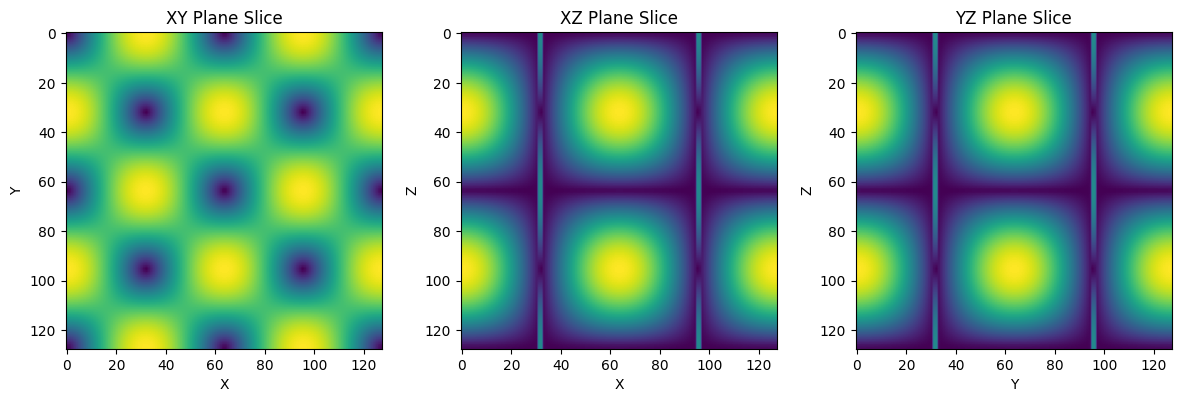

In [22]:
# 可视化切片
fig, axes = plt.subplots(1, 3, figsize=(12, 10))

# 选择一个切片位置
slice_index = size // 2

plt.subplot(1, 3, 1)
# x-y 平面切片
plt.imshow( U_magnitude[:, :, slice_index],  cmap='viridis')
plt.title('XY Plane Slice')
plt.xlabel('X')
plt.ylabel('Y')
# axes[0, 0].streamplot(X[:, :, slice_index], Y[:, :, slice_index], U_x[:, :, slice_index], U_y[:, :, slice_index], color='white')

plt.subplot(1, 3, 2)
# x-z 平面切片
plt.imshow(U_magnitude[:, slice_index, :], cmap='viridis')
plt.title('XZ Plane Slice')
plt.xlabel('X')
plt.ylabel('Z')
# axes[0, 1].streamplot(X[:, slice_index, :], Z[:, slice_index, :], U_x[:, slice_index, :], U_z[:, slice_index, :], color='white')

plt.subplot(1, 3, 3)
# y-z 平面切片
plt.imshow( U_magnitude[slice_index, :, :], cmap='viridis')
plt.title('YZ Plane Slice')
plt.xlabel('Y')
plt.ylabel('Z')
# axes[1, 0].streamplot(Y[slice_index, :, :], Z[slice_index, :, :], U_y[slice_index, :, :], U_z[slice_index, :, :], color='white')


plt.tight_layout()
# plt.savefig('result/velocity_field_3d_slices.png', dpi=500)
plt.show()


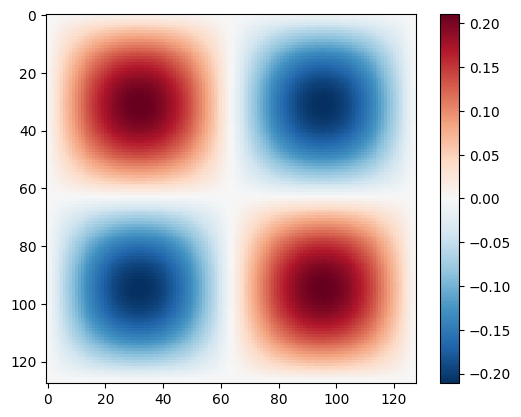

In [23]:
plt.imshow(vorticity_z_normalized[:, :, size // 2], cmap='RdBu_r',interpolation='nearest')
plt.colorbar()

# 数据输出到paraview

In [24]:
import numpy as np
import pyvista as pv

# 计算 u_x, u_y, u_z 的梯度
grad_u0_x, grad_u0_y, grad_u0_z = np.gradient(U_x, dx, dy, dz)
grad_u1_x, grad_u1_y, grad_u1_z = np.gradient(U_y, dx, dy, dz)
grad_u2_x, grad_u2_y, grad_u2_z = np.gradient(U_z, dx, dy, dz)

In [25]:
# 计算指定的公式
energy_density = -0.5 * (
    grad_u0_x**2 + grad_u0_y*grad_u1_x + grad_u0_z*grad_u2_x +
    grad_u1_x*grad_u0_y + grad_u1_y**2 + grad_u1_z*grad_u2_y +
    grad_u2_x*grad_u0_z + grad_u2_y*grad_u1_z + grad_u2_z**2
)


In [28]:
import pyvista as pv

# 创建 PyVista 网格对象
grid = pv.StructuredGrid()
grid.points = np.column_stack((X.ravel(order='F'), Y.ravel(order='F'), Z.ravel(order='F')))
grid.dimensions = (size, size, size)

# 添加速度场向量
grid['u0'] = U_x.ravel(order='F')
grid['u1'] = U_y.ravel(order='F')
grid['u2'] = U_z.ravel(order='F')

# 添加梯度
grid['grad_u0_x'] = grad_u0_x.ravel(order='F')
grid['grad_u0_y'] = grad_u0_y.ravel(order='F')
grid['grad_u0_z'] = grad_u0_z.ravel(order='F')
grid['grad_u1_x'] = grad_u1_x.ravel(order='F')
grid['grad_u1_y'] = grad_u1_y.ravel(order='F')
grid['grad_u1_z'] = grad_u1_z.ravel(order='F')
grid['grad_u2_x'] = grad_u2_x.ravel(order='F')
grid['grad_u2_y'] = grad_u2_y.ravel(order='F')
grid['grad_u2_z'] = grad_u2_z.ravel(order='F')

# 添加计算出的能量密度
grid['energy_density'] = energy_density.ravel(order='F')

grid['U_magnitude'] = U_magnitude.ravel(order='F')

# 保存到 VTK 文件
grid.save('velocity_and_energy_density.vtk')


In [30]:
import numpy as np
import pyvista as pv

# 计算 u_x, u_y, u_z 的梯度
grad_u0_x, grad_u0_y, grad_u0_z = np.gradient(U_x, dx, dy, dz)
grad_u1_x, grad_u1_y, grad_u1_z = np.gradient(U_y, dx, dy, dz)
grad_u2_x, grad_u2_y, grad_u2_z = np.gradient(U_z, dx, dy, dz)

# 创建 PyVista 网格对象
grid = pv.StructuredGrid()
grid.points = np.column_stack((X.ravel(order='F'), Y.ravel(order='F'), Z.ravel(order='F')))
grid.dimensions = (size, size, size)

# 添加速度场向量
grid['u0'] = U_x.ravel(order='F')
grid['u1'] = U_y.ravel(order='F')
grid['u2'] = U_z.ravel(order='F')

# 添加梯度
grid['grad_u0_X'] = grad_u0_x.ravel(order='F')
grid['grad_u0_Y'] = grad_u0_y.ravel(order='F')
grid['grad_u0_Z'] = grad_u0_z.ravel(order='F')
grid['grad_u1_X'] = grad_u1_x.ravel(order='F')
grid['grad_u1_Y'] = grad_u1_y.ravel(order='F')
grid['grad_u1_Z'] = grad_u1_z.ravel(order='F')
grid['grad_u2_X'] = grad_u2_x.ravel(order='F')
grid['grad_u2_Y'] = grad_u2_y.ravel(order='F')
grid['grad_u2_Z'] = grad_u2_z.ravel(order='F')

# 添加计算出的能量密度
grid['energy_density'] = energy_density.ravel(order='F')

# 添加合速度
grid['U_magnitude'] = U_magnitude.ravel(order='F')

# 保存到 VTK 文件
grid.save('velocity_and_energy_density_with_magnitude1.vtk')


In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path = r'D:\zjPhD\turbulenceData\matlab\velocity_data.mat'

# 读取 .mat 文件
data = scipy.io.loadmat(file_path)


In [4]:
ux = np.array(data['ux'])
uy = np.array(data['uy'])

In [5]:
# 打印数组的形状以验证
print("ux shape:", ux.shape)
print("uy shape:", uy.shape)

ux shape: (64, 64)
uy shape: (64, 64)


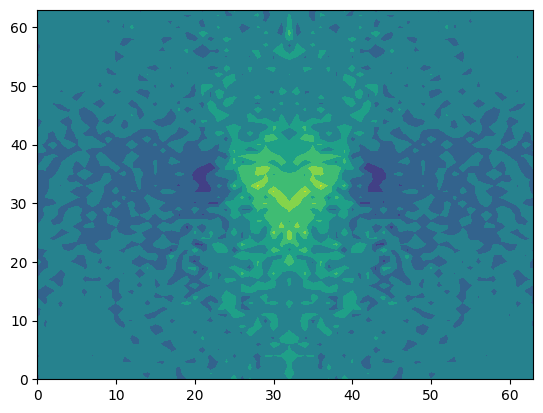

In [8]:
plt.contourf(ux, cmap='viridis')

In [9]:
U_magnitude = np.sqrt(ux**2 + uy**2)

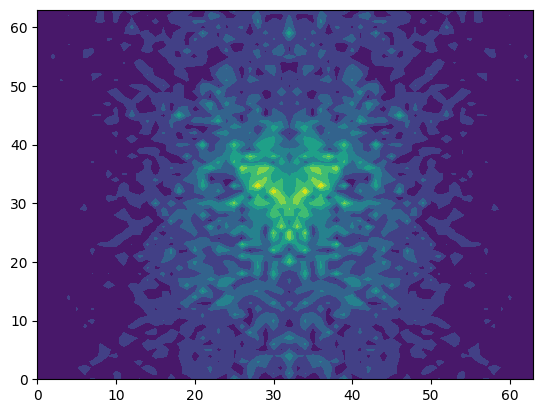

In [10]:
plt.contourf(U_magnitude, cmap='viridis')

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [41]:
U_x_tensor = torch.tensor(ux, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
U_y_tensor = torch.tensor(ux, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
U_magnitude_tensor = torch.tensor(U_magnitude, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)



In [17]:
all_velocity_fields = []
velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)

all_velocity_fields.append(velocity_field)

all_velocity_fields = torch.cat(all_velocity_fields, dim=0)


In [42]:
num_samples = all_velocity_fields.shape[0]
size_low = all_velocity_fields.shape[2]
target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)
    # 创建数据集和数据加载器
dataset = TensorDataset(all_velocity_fields, target_abcd)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # 你可以根据需要调整batch_size

# 检查数据形状
print("all_velocity_fields shape:", all_velocity_fields.shape)
print("target_abcd shape:", target_abcd.shape)


all_velocity_fields shape: torch.Size([1, 3, 64, 64])
target_abcd shape: torch.Size([1, 4, 64, 64])


In [43]:
size_low = 64

dx = 2*np.pi/size_low
dy = 2*np.pi/size_low
dz = 2*np.pi/size_low

In [44]:
u_test =all_velocity_fields[0,0,:,:].numpy()
v_test =all_velocity_fields[0,1,:,:].numpy()
w_test =all_velocity_fields[0,2,:,:].numpy()

In [45]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy


# 计算归一化的涡度
def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized


In [46]:
vort_test = vorticity(u_test, v_test, dx, dx)

vorticity_normalized = vorticity_normalize(vort_test)

print(vort_test.shape)
print(vorticity_normalized.shape)

(64, 64)
(64, 64)


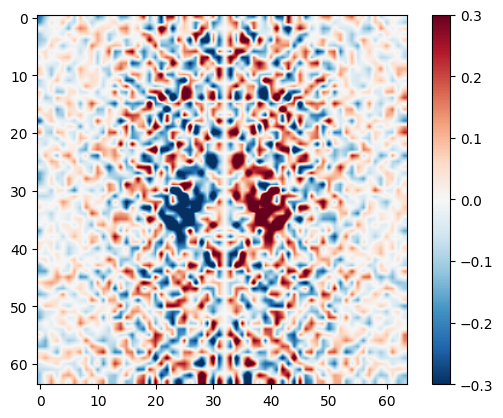

In [47]:
plt.imshow(vorticity_normalized, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()

In [48]:
class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)
        x = self.conv5(x)
        return x


In [49]:
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        return x


In [50]:
class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)
        x = x / norm
        return x


In [51]:
class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x


In [52]:
def calculate_gradients_with_numpy(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    return grad_x_tensor, grad_y_tensor


In [53]:
def laplacian_2d_torch(tensor, dx, dy):
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)
    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)
    laplacian = laplacian_x_tensor + laplacian_y_tensor
    return laplacian


In [54]:
def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):

    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]

    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)

    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    loss_velocity = F.mse_loss(U_magnitude_pred, U_magnitude_true) + F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true)

    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))

    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()

    l1_regularization = torch.tensor(0., requires_grad=True)

    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_regularization = torch.tensor(0., requires_grad=True)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization
    return total_loss


In [55]:
learning_rate = 0.00001
num_epochs = 18000
epsilon = 0.01
l1_lambda = 0.001
l2_lambda = 0.001
channels = 3


In [56]:
model = ComplexModelA().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')


Epoch [1/18000], Step [1], Loss: 136.4151
Epoch [2/18000], Step [1], Loss: 136.2117
Epoch [3/18000], Step [1], Loss: 136.0088
Epoch [4/18000], Step [1], Loss: 135.8055
Epoch [5/18000], Step [1], Loss: 135.6034
Epoch [6/18000], Step [1], Loss: 135.4015
Epoch [7/18000], Step [1], Loss: 135.1998
Epoch [8/18000], Step [1], Loss: 134.9992
Epoch [9/18000], Step [1], Loss: 134.7997
Epoch [10/18000], Step [1], Loss: 134.6004
Epoch [11/18000], Step [1], Loss: 134.4023
Epoch [12/18000], Step [1], Loss: 134.2055
Epoch [13/18000], Step [1], Loss: 134.0092
Epoch [14/18000], Step [1], Loss: 133.8141
Epoch [15/18000], Step [1], Loss: 133.6206
Epoch [16/18000], Step [1], Loss: 133.4278
Epoch [17/18000], Step [1], Loss: 133.2364
Epoch [18/18000], Step [1], Loss: 133.0464
Epoch [19/18000], Step [1], Loss: 132.8573
Epoch [20/18000], Step [1], Loss: 132.6692
Epoch [21/18000], Step [1], Loss: 132.4826
Epoch [22/18000], Step [1], Loss: 132.2970
Epoch [23/18000], Step [1], Loss: 132.1125
Epoch [24/18000], St

In [58]:
predicted_abcd.shape

torch.Size([1, 4, 64, 64])

In [59]:
predicted_abcd = predicted_abcd.cpu()  # 将预测结果移回CPU以便进行后续处理和可视化
a_pre = predicted_abcd[0,0,:,:].detach().numpy()
b_pre = predicted_abcd[0,1,:,:].detach().numpy()
c_pre = predicted_abcd[0,2,:,:].detach().numpy()
d_pre = predicted_abcd[0,3,:,:].detach().numpy()


In [60]:
a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)
U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)



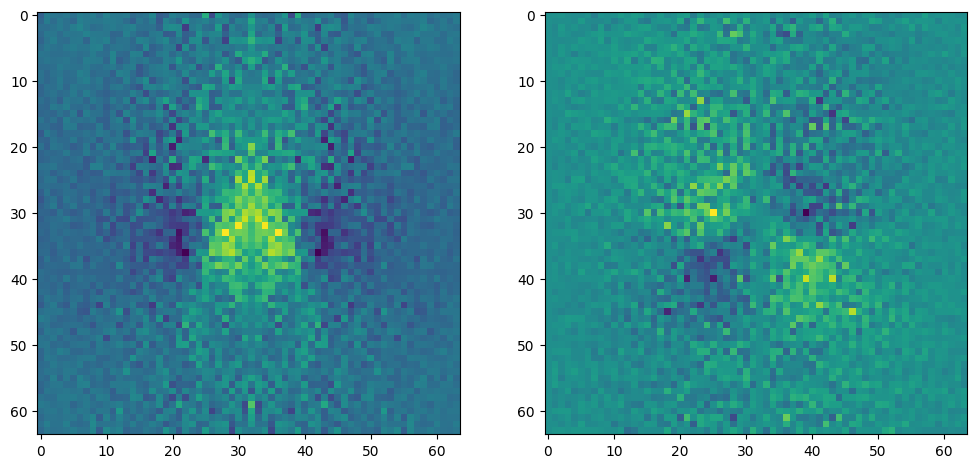

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')



In [62]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized



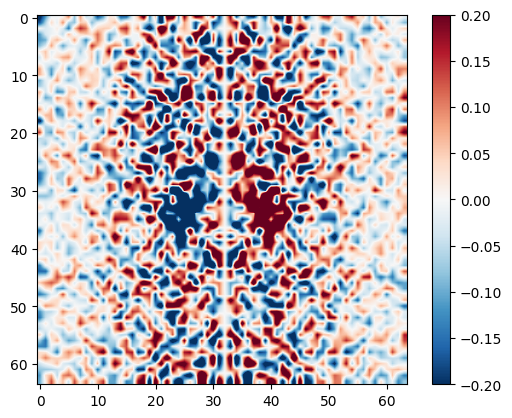

In [63]:
vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)
vorticity_normalized_pre = vorticity_normalize(vort_pre)
plt.imshow(vorticity_normalized_pre, cmap='RdBu_r', vmin=-0.2, vmax=0.2, interpolation='bilinear')
plt.colorbar()